# Fake News detection with tensorflow and nltk using LSTMs

In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score, recall_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

plt.style.use("ggplot")

# Base LSTM+ multimodal model

## Load data with features

In [2]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip && unzip -o -d data train-checkpoint3.zip

--2023-04-12 20:41:07--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip [following]
--2023-04-12 20:41:07--  https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85963394 (82M) [application/zip]
Saving to: ‘train-checkpoint3.zip.1’

train-checkpoint3.z 100%[===================>]  81.98M   222MB/s    in 0.4s    

2023-04-12 20

In [3]:
df = pd.read_csv("/kaggle/working/data/train-checkpoint3.csv", index_col=False)

In [4]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,text,text_norm,gulpease_index,smog_index,mean_word_len,real
0,isis leader ‘hiding in mosul’ as troops storm ...,"['isi', 'leader', 'hiding', 'mosul', 'troop', ...",51.2,12.9,5.808260,0.0
1,former speaker john boehner goes low…calls two...,"['former', 'speaker', 'john', 'boehner', 'go',...",62.3,9.9,5.899160,0.0
2,mh370 search: debris found in reunion may give...,"['mh370', 'search', 'debris', 'found', 'reunio...",51.0,13.1,6.231598,1.0
3,a leading us senator: us supporting war in sy...,"['leading', 'u', 'senator', 'u', 'supporting',...",48.0,15.2,6.139583,0.0
4,energy update – collective gridwork fluctuatio...,"['energy', 'update', 'collective', 'gridwork',...",55.8,12.3,6.546789,0.0


In [6]:
df = df.loc[:, df.columns != "text"] # Remove standalone text column

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != "real"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [8]:
X_train

,text_norm,gulpease_index,smog_index,mean_word_len
32162,"['watch', 'news', 'camera', 'catch', 'drug', '...",45.1,0.0,5.555556
14001,"['state', 'department', 'say', 'find', 'email'...",49.6,12.9,6.414573
35625,"['trump', 'visit', 'asia', 'november', 'north'...",50.5,13.8,6.373434
37911,"['colombia', 'farc', 'leader', 'timochenko', '...",48.4,14.0,6.372624
36360,"['trump', 'torture', 'session', 'every', 'day'...",54.7,11.1,5.973684
...,...,...,...,...
6265,"['breaking', 'hispanic', 'men', 'coward', 'bea...",53.0,10.5,5.571429
11284,"['democratic', 'hopeful', 'sander', 'clinton',...",51.5,13.3,6.394256
38158,"['france', 'say', 'saudi', 'coalition', 'must'...",48.5,12.5,6.228070
860,"['palestinian', 'call', 'emergency', 'meeting'...",57.5,13.7,6.363636


In [9]:
X_train.describe()

,gulpease_index,smog_index,mean_word_len
count,34042.000000,34042.000000,34042.000000
mean,52.411480,11.969294,6.101352
std,5.576825,3.484700,0.396024
min,-47.900000,0.000000,3.649660
25%,49.000000,11.200000,5.877928
50%,52.000000,12.500000,6.121951
75%,55.400000,13.800000,6.352941
max,115.000000,28.600000,9.333333


In [10]:
X_train.dtypes

text_norm          object
gulpease_index    float64
smog_index        float64
mean_word_len     float64
dtype: object

In [11]:
y_train.describe()

count    34042.000000
mean         0.439134
std          0.496289
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: real, dtype: float64

Data looks good to create a model

## Final data processing (before model)

I expect a pandas DF that has the columns
- text_norm - Array of splitted and lemmatized words (English only)
- gulpease_index - ...
- smog_index - ...
- mean_word_len - Mean of lengths of words in the text_norm array

In [12]:
MAX_VOCAB = 20000
MAX_LEN = 256

In [13]:
class ModelInputCreator(BaseEstimator, TransformerMixin):
    def __init__(self, max_vocab: int, max_len: int, texts_column: str, numerical_columns: List[str]):
        self.max_vocab = max_vocab
        self.max_len = max_len
        self.texts_column = texts_column
        self.numerical_columns = numerical_columns
        self.scaler = StandardScaler()
        self.tokenizer = Tokenizer(num_words=MAX_VOCAB)
        
    def fit(self, df: pd.DataFrame):
        df = df.reset_index(drop=True)
        self.tokenizer.fit_on_texts(df[self.texts_column])
        self.scaler.fit(df[self.numerical_columns])
        return self
    
    def transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        text_sequences = self.tokenizer.texts_to_sequences(df[self.texts_column])
        text_sequences = pad_sequences(text_sequences, padding="post", maxlen=MAX_LEN)
        numerical = self.scaler.transform(df[self.numerical_columns])
        return (text_sequences, numerical)
    
    def fit_transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        self.fit(df)
        return self.transform(df)

In [14]:
input_creator = ModelInputCreator(
    max_vocab = MAX_VOCAB,
    max_len = MAX_LEN,
    texts_column = "text_norm",
    numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
)

In [15]:
X_train_transformed = input_creator.fit_transform(X_train)

In [16]:
X_train_transformed

(array([[ 270,   36, 1742, ...,    0,    0,    0],
        [ 815,   97,  989, ...,  285, 2645,   80],
        [ 163,    4,  312, ...,  602,   42,    2],
        ...,
        [ 890,   16,  418, ...,    0,    0,    0],
        [ 939,  142, 1354, ...,    0,    0,    0],
        [ 603, 1808,   16, ...,    0,    0,    0]], dtype=int32),
 array([[-1.31106621, -3.4348642 , -1.37820918],
        [-0.50414367,  0.26708755,  0.79092515],
        [-0.34275916,  0.52536325,  0.68704293],
        ...,
        [-0.7013914 ,  0.15229835,  0.31998076],
        [ 0.91245367,  0.49666595,  0.66230363],
        [-0.89863913,  0.61145515,  0.45234232]]))

# RNN Model

## Model building

In [31]:
text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
text_features = tf.keras.layers.Embedding(MAX_VOCAB, 128)(text_input)

text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)

num_input = tf.keras.Input(shape=(3,), name="num_input")
num_features = tf.keras.layers.Dense(32, activation='relu')(num_input)

merged = tf.keras.layers.concatenate([text_features, num_features])
merged = tf.keras.layers.Dense(8)(merged)
merged = tf.keras.layers.Dropout(0.5)(merged)
output = tf.keras.layers.Dense(1)(merged)

model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 256, 128)     2560000     ['text_input[0][0]']             
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 256, 128)    98816       ['embedding_6[0][0]']            
 l)                                                                                               
                                                                                                  
 num_input (InputLayer)         [(None, 3)]          0           []                         

## Model fitting

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1022/1022 [==============================] - 89s 80ms/step - loss: 0.3434 - accuracy: 0.8387 - val_loss: 0.1677 - val_accuracy: 0.9392
Epoch 2/10
1022/1022 [==============================] - 46s 45ms/step - loss: 0.1444 - accuracy: 0.9548 - val_loss: 0.1301 - val_accuracy: 0.9510
Epoch 3/10
1022/1022 [==============================] - 43s 42ms/step - loss: 0.0822 - accuracy: 0.9766 - val_loss: 0.1442 - val_accuracy: 0.9557
Epoch 4/10
 256/1022 [======>.......................] - ETA: 29s - loss: 0.0669 - accuracy: 0.9824

## Training Visualization

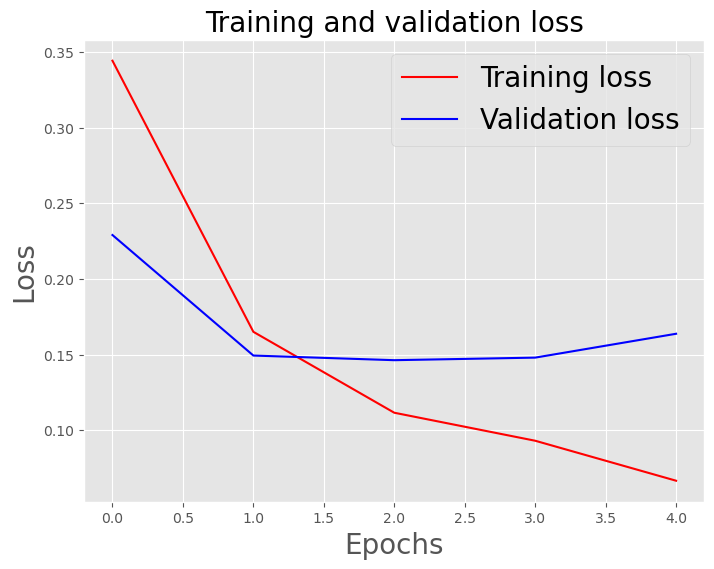

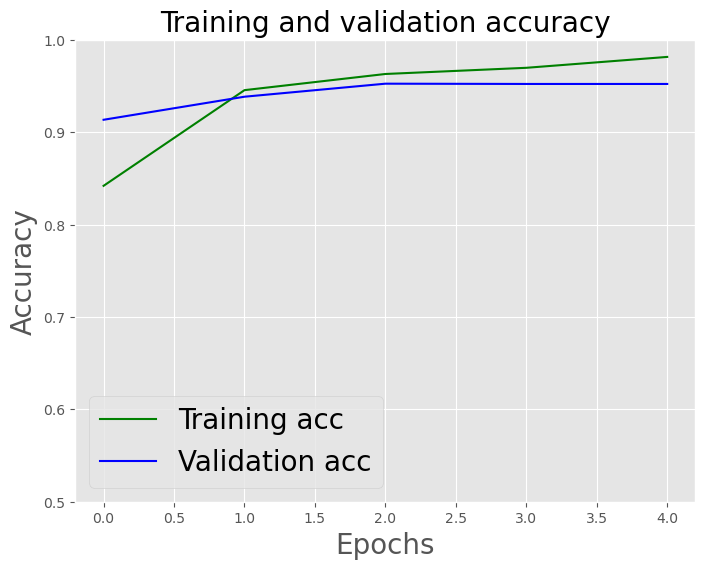

In [23]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Testing

Evaluation of the testing set:

In [25]:
X_test_transformed = input_creator.transform(X_test)

In [26]:
model.evaluate(X_test_transformed, y_test)

266/266 [==============================] - 4s 15ms/step - loss: 0.1592 - accuracy: 0.9458


[0.1592496633529663, 0.9458348155021667]

In [124]:
y_pred = model.predict(test_inputs)
roc05 = (y_pred > 0.5) * 1

266/266 [==============================] - 4s 16ms/step


### Confusion Matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

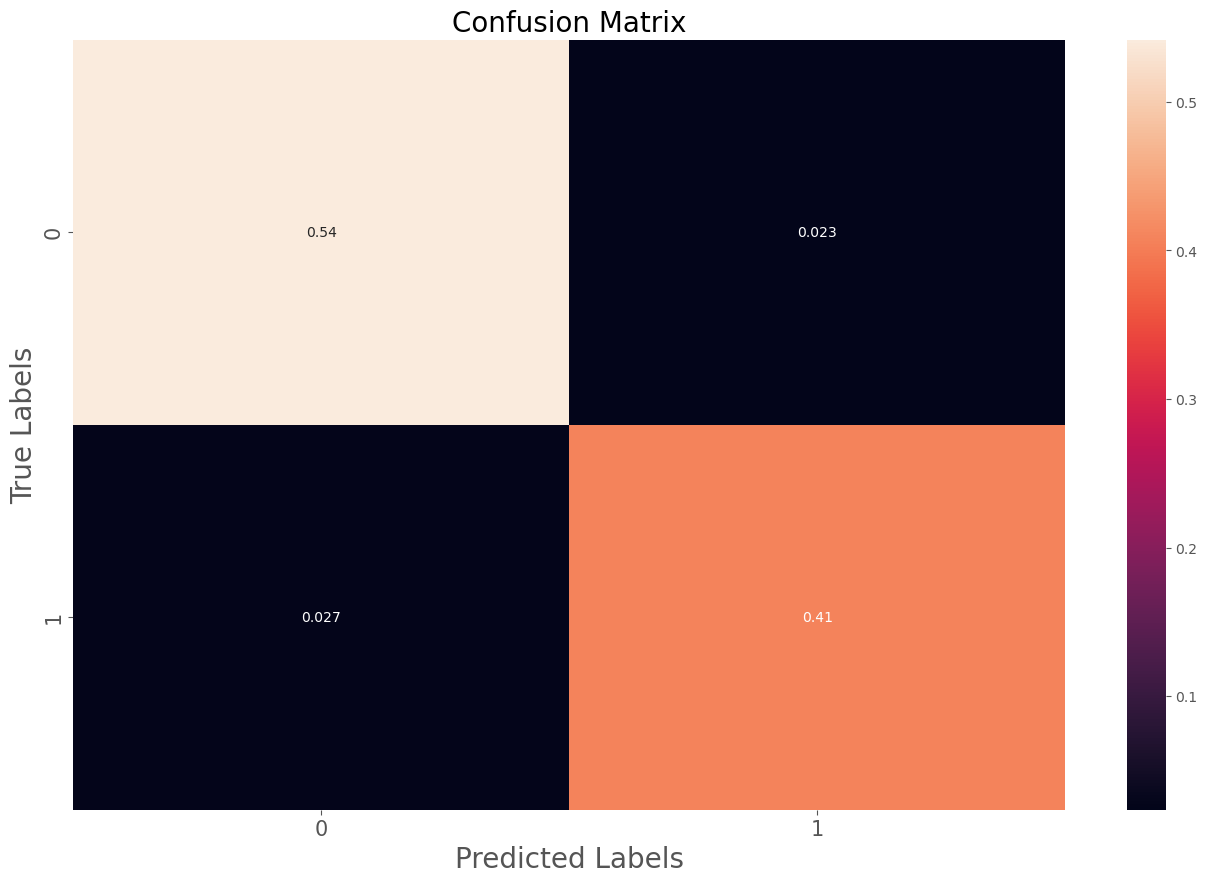

In [125]:
matrix = confusion_matrix(roc05, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

### ROC Curve

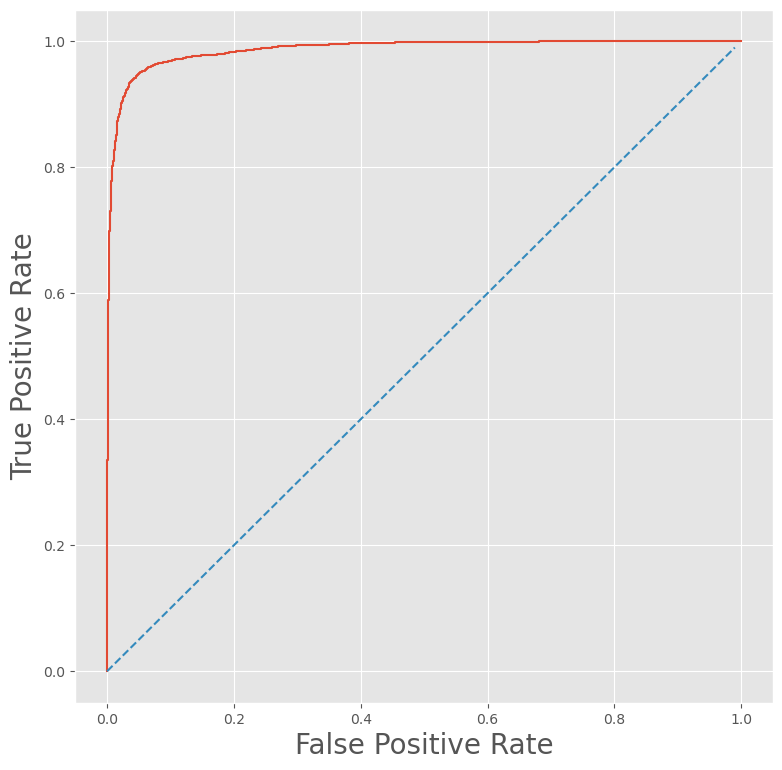

In [126]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.figure(figsize=(9,9))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()

# XGBoost

In [143]:
# Get predictions from the current model
current_model_preds = model.predict(inputs_train)

1064/1064 [==============================] - 18s 16ms/step


In [144]:
inputs_train_xbg = np.concatenate(inputs_train, axis=1)

In [118]:
# Train an XGBoost model on the training data, and get predictions for the test data
xgb_model = xgb.XGBClassifier(
    max_depth = 5,
    learning_rate = 0.08,
    objectives = "binary:logistic"
)
xgb_model.fit(inputs_train_xbg, y_train)

[19:56:05] WARNING: ../src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objectives='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [146]:
xgb_preds = xgb_model.predict(inputs_train_xbg)

In [147]:
# Concatenate the predictions from the two models
combined_preds = np.concatenate((current_model_preds, xgb_preds.reshape(-1, 1)), axis=1)

In [157]:
# Train a new model on the combined predictions
new_model = tf.keras.Sequential([
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])
new_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [158]:
new_model.fit(combined_preds, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1022/1022 [==============================] - 5s 4ms/step - loss: 0.5066 - accuracy: 0.7408 - val_loss: 0.1802 - val_accuracy: 0.9536
Epoch 2/10
1022/1022 [==============================] - 4s 4ms/step - loss: 0.1855 - accuracy: 0.9242 - val_loss: 0.1445 - val_accuracy: 0.9527
Epoch 3/10
1022/1022 [==============================] - 4s 4ms/step - loss: 0.1305 - accuracy: 0.9548 - val_loss: 0.1472 - val_accuracy: 0.9530
Epoch 4/10
1022/1022 [==============================] - 4s 4ms/step - loss: 0.1138 - accuracy: 0.9644 - val_loss: 0.1527 - val_accuracy: 0.9533


In [160]:
test_inputs = input_creator.transform(X_test)
inputs_test_xbg = np.concatenate(inputs_test, axis=1)

In [162]:
lstm_test_preds = model.predict(inputs_test)
xgb_test_preds = xgb_model.predict(inputs_test_xbg)

266/266 [==============================] - 5s 18ms/step


In [163]:
concat_test_preds = np.concatenate((lstm_test_preds, xgb_test_preds.reshape(-1, 1)), axis=1)

In [164]:
new_model.evaluate(concat_test_preds, y_test)

266/266 [==============================] - 1s 4ms/step - loss: 0.1493 - accuracy: 0.9491


[0.14932160079479218, 0.9491246342658997]

In [165]:
y_pred = model.predict(test_inputs)
roc05 = (y_pred > 0.5) * 1

266/266 [==============================] - 4s 16ms/step


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

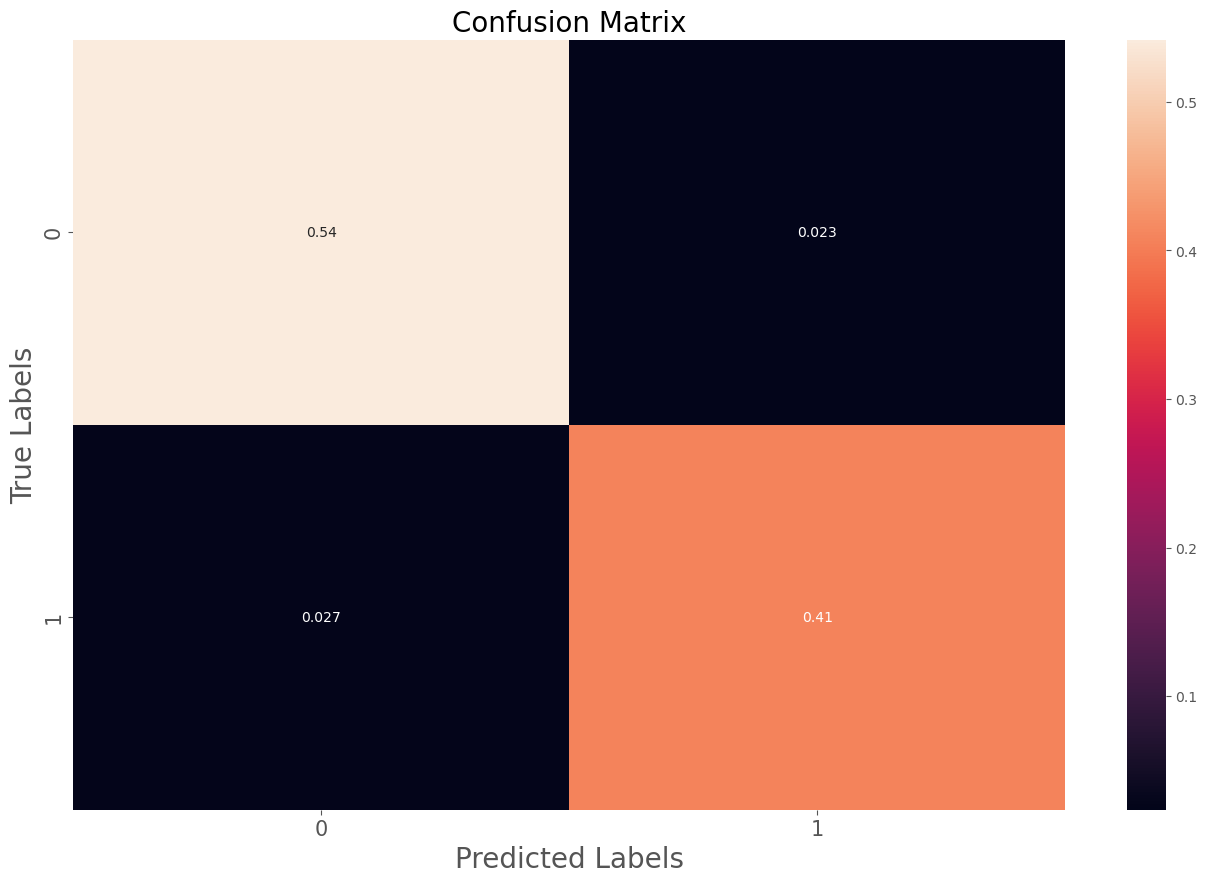

In [166]:
matrix = confusion_matrix(roc05, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)